In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from camera import CameraReader, display_frame
import ipywidgets as widgets
import numpy as np
import sys
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import pywt
from scipy.cluster.vq import vq
from sklearn.cluster import KMeans
from matplotlib import animation, patches
from scipy import fftpack
from scipy.signal import fftconvolve, convolve2d
from IPython.display import display, Audio, HTML
from style import *
%matplotlib notebook
plt.rcParams['image.cmap'] = 'gray'



Iniciando lector de camara
OpenCV version: major: 4, minor: 1, subminor: 0
Resolución del video: 848x480p
Cuadros por segundo: 29.97002997002997


<IPython.core.display.Javascript object>


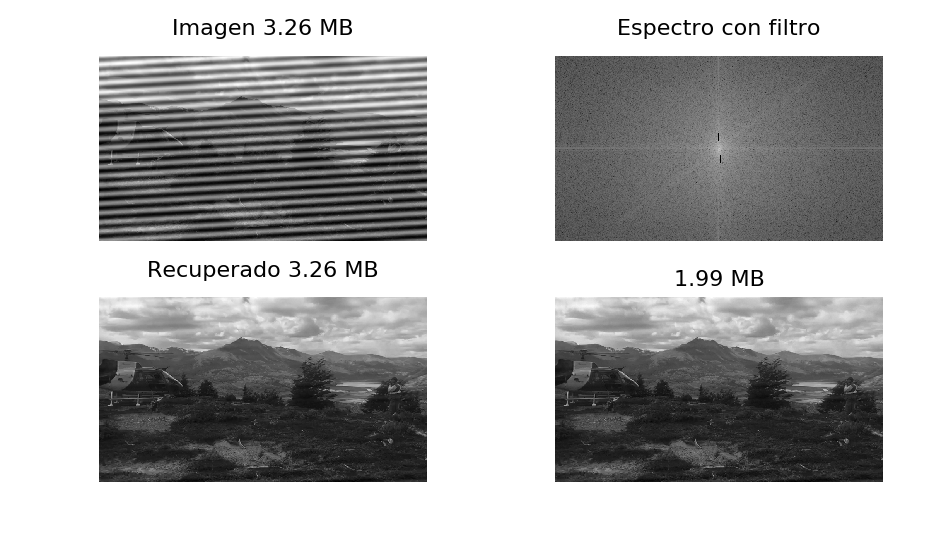

/home/panda/.local/lib/python3.5/site-packages/ipykernel_launcher.py:91: ComplexWarning: Casting complex values to real discards the imaginary part


Tamaño frame original: 3.26 MB
Tamaño frame filtrado: 3.26 MB
Tamaño frame comprimido: 1.99 MB


1

In [133]:
cam = CameraReader()
vid_height, vid_width = cam.get_resolution()
print("Resolución del video: {0}x{1}p".format(vid_width, vid_height))
print("Cuadros por segundo: {0}".format(cam.get_fps()))

out = widgets.Image(layout=widgets.Layout(width=str(vid_width), 
                                           height=str(vid_height)))
#display(out)
count = 0;

#Mostrar en cuadros
fig, ax = plt.subplots(2, 2, figsize=(7,4), tight_layout=True)

#play = widgets.Play

size_y=10
size_x=2
frequency=28

for frame in cam:
    
    # Implemente una función que limpie los frames
    frame_sp = fftpack.fftshift(fftpack.fft2(frame))
    frame_s = frame_sp*1
    frame_limpio = frame_sp
    #Filtro para ruido periodico
    frame_limpio[240-size_y-1-frequency:240+size_y-1-frequency, 420-size_x+4:420+size_x+2] = 0
    frame_limpio[240-size_y+frequency:240+size_y+frequency, 420-size_x+8:420+size_x+6] = 0
    frame_revuelto = np.abs(fftpack.ifft2(fftpack.ifftshift(frame_limpio))).astype(np.uint8)
    #print(sys.getsizeof(frame_limpio))  #getsizeof retorna el tamaño en Bytes
    
    # Implemente una función que comprima los frames
    # frame_comprimido = comprimir(frame)
    # print(sys.getsizeof(frame_comprimido))
    
    # Implemente una función que descomprima los frames
    # frame = descomprimir(frame_compromido)
    # print(cam.error(frame))  # Error de compresión
    count +=1;
    
    
    #display_frame(out, frame)
    #display_frame(out,frame_revuelto.astype(np.uint8))
    
    if(count==1):
        area_o = frame.shape[0]*frame.shape[1]
        break;

#ax[0,0].matshow(frame);#ax[0,0].set_title("Imagen")
#ax[0,1].matshow(np.log(np.abs(frame_s)));#ax[0,1].set_title("Espectro")
    

#Transformada de coseno y su inversa
DCT2 = lambda g, norm='ortho': fftpack.dct( fftpack.dct(g, axis=0, norm=norm), axis=1, norm=norm)
IDCT2 = lambda G, norm='ortho': fftpack.idct( fftpack.idct(G, axis=0, norm=norm), axis=1, norm=norm)

#Datos de utilidad para JPEG
area_fr = frame_revuelto.shape[0]*frame_revuelto.shape[1]
imsize = frame_revuelto.shape
percent = 100

#Matriz Q
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],[12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],[14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],[24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],[72, 92, 95, 98, 112, 100, 103, 99]])

#Matriz transformada de coseno y transformada de fourier
dct_matrix = np.zeros(shape=imsize)
dft_matrix = np.zeros(shape=imsize, dtype=np.complex128)

#Llenado de matrices de DCT y DFT
for i in range(0, imsize[0], 8):
    for j in range(0, imsize[1], 8):
        dct_matrix[i:(i+8),j:(j+8)] = DCT2( frame_revuelto.astype(np.complex128)[i:(i+8),j:(j+8)] )
        dft_matrix[i:(i+8),j:(j+8)] = fftpack.fft2( frame_revuelto.astype(np.complex128)[i:(i+8),j:(j+8)] )

#Nose que hace aquí pero supongo que funciona
for ax_ in ax.ravel():
    ax_.cla(); ax_.axis('off')
    im_dct = np.zeros(imsize)                                  #im_dct es la imagen
    nnz = np.zeros(dct_matrix.shape)                           #de nnz sacamos el tamaño reducido
    if (percent < 50):
        S = 5000/percent
    else:
        S = 200 - 2*percent 
    Q_dyn = np.floor((S*Q + 50) / 100);
    Q_dyn[Q_dyn == 0] = 1
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            quant = np.round(dct_matrix[i:(i+8),j:(j+8)]/Q_dyn) 
            im_dct[i:(i+8),j:(j+8)] = IDCT2(quant)
            nnz[i, j] = np.count_nonzero(quant)
#Quizas el codigo del jupyter esta malo a proposito pa q no lo referenciemos
            
#Salidas en plot
ax[0,0].matshow(frame);ax[0,0].set_title("Imagen %0.2f MB" %(area_o*8/1e+6))           
ax[1,1].imshow(im_dct); 
ax[1,1].set_title("%0.2f MB" %(np.sum(nnz)*8/1e+6))

ax[0,1].matshow(np.log(np.abs(frame_limpio)+1));ax[0,1].set_title("Espectro con filtro")
ax[1,0].matshow(np.mean(frame) + np.abs(fftpack.ifft2(fftpack.ifftshift(frame_limpio))));
ax[1,0].set_title("Recuperado %0.2f MB" %(area_fr*8/1e+6))

print("Tamaño frame original: %0.2f MB" %(area_o*8/1e+6))
print("Tamaño frame filtrado: %0.2f MB" %(area_fr*8/1e+6))
print("Tamaño frame comprimido: %0.2f MB" %(np.sum(nnz)*8/1e+6))
#print("{0} MB".format(sys.getsizeof(frame)/1e6))
#print("{0} MB".format(sys.getsizeof(frame_revuelto)/1e6))
#print("{0} MB".format(sys.getsizeof(nnz)/1e6))
count


In [46]:
#fftpack.fftshift(np.log(1+np.abs(fftpack.fft2(frame.astype('float32')))))